### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

log_root = Path('./logs')
checkpoint_path = log_root / 'checkpoints'

In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'ViT-OC-CIFAR10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [3]:
# initialize ViT model and load pretrained weights
from models.vit import ViT

model = ViT(
    image_size=config.dataset.img_size,
    patch_size=config.model.patch_size,
    num_classes=len(config.dataset.in_distribution_class_indices),
    dim=config.model.dim_head,
    depth=config.model.depth,
    heads=config.model.n_heads,
    mlp_dim=config.model.dim_mlp,
    dropout=config.model.dropout,
    emb_dropout=config.model.emb_dropout,
    visualize=True,
)

if device == 'cuda':
    model = model.to(device)
    model = torch.nn.DataParallel(model) # make parallel

model_name = config.model.name
patch_size = config.model.patch_size
checkpoint = torch.load(checkpoint_path / f'{model_name}-patch{patch_size}-ckpt.t7')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

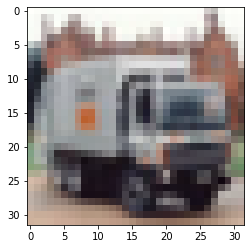

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
torch.return_types.max(
values=tensor([10.9446], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0')) tensor([[ 2.0908, 10.9446, -2.9262, -1.6959, -5.0676, -2.1707, -1.7368, -0.8264,
          5.2797]], device='cuda:0', grad_fn=<GatherBackward>)
6 torch.Size([1, 8, 65, 65])


In [12]:
from datasets import OC_CIFAR10

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.dataset.img_size
in_distribution_class_indices = config.dataset.in_distribution_class_indices

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

dataset = OC_CIFAR10(
    root=dataset_root, 
    in_distribution_class_indices=in_distribution_class_indices, 
    train=False, 
    download=False, 
    transform=transform_test
)

class_indices = list(range(10))
ood_class_indices = [i for i in class_indices if i not in in_distribution_class_indices]
plt.imshow(dataset.img_dict[ood_class_indices[0]][0])
plt.show()
processed_img = dataset.get_sample_image(ood_class_indices[0], 0)
logit, attn_weights = model(processed_img.unsqueeze(0))
print(dataset.class_to_idx)
print(logit.max(1), logit)
print(len(attn_weights), attn_weights[0].shape)